In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate

from tensorflow.keras.callbacks import ModelCheckpoint

from keras import backend as K

from keras.datasets import mnist

import tensorflow as tf
import tensorflow_probability as tfp # for tf version 2.0.0, tfp version 0.8 is needed 
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

False

---

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

---

In [45]:
def generate_data(batch_size, max_num_context, testing=False, digit = None, labels = False, img_rows = 28, img_cols = 28):
    max_num_points = img_rows*img_cols
    
    if max_num_context > max_num_points:
        num_context = np.random.randint(3, max_num_points, dtype='int32')
    else:
        num_context = np.random.randint(3, max_num_context, dtype='int32')
    
    # [img_rows, img_cols]
    row_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_rows, dtype='float32'), axis=0), [img_cols,1])
    # [img_cols, img_rows]
    col_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_cols, dtype='float32'), axis=0), [img_rows,1])
    # [img_rows*img_cols, 2]
    x_pairs = np.reshape(np.concatenate((np.expand_dims(np.transpose(row_dim), axis=-1), np.expand_dims(col_dim, axis=-1)), axis=-1), [max_num_points,2])
    
    
    if testing:
        num_target_points = max_num_points
        set_x = x_test
        set_y = y_test
    else:
        num_target_points = np.random.randint(num_context, max_num_points+1, dtype='int32')
        set_x = x_train
        set_y = y_train
    
    context_x = np.zeros([batch_size, num_context, 2])
    context_y = np.zeros([batch_size, num_context, 1])
    
    target_x = np.zeros([batch_size, num_target_points, 2])
    target_y = np.zeros([batch_size, num_target_points, 1])
    
    if labels:
        labels_y = np.zeros([batch_size, 1], dtype='int8')
    
    idx_1 = np.arange(set_x.shape[0])
    np.random.shuffle(idx_1)
        
    for i in range(batch_size):
        
        if digit != None:
            for j in range(set_x.shape[0]):
                if digit == set_y[idx_1[j]]:
                    break
        else:
            j = i
            
        if labels:
            labels_y[i] = set_y[idx_1[j]]
        
        img = np.reshape(set_x[idx_1[j]], [max_num_points,1])/255
        
        idx_2 = np.arange(max_num_points)
        np.random.shuffle(idx_2)
        
        context_x[i] = x_pairs[idx_2[:num_context]]
        context_y[i] = img[idx_2[:num_context]]
        
        if testing:
            target_x[i] = x_pairs
            target_y[i] = img
        else:
            target_x[i] = x_pairs[idx_2[:num_target_points]]
            target_y[i] = img[idx_2[:num_target_points]]


    context_xy = np.concatenate([context_x, context_y], axis=-1)
    
    if labels:
        return [context_xy, target_x], target_y, labels_y    
    
    return [context_xy, target_x], target_y   

In [46]:
def generate(batch_size, max_num_context, testing):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        inputs, targets = generate_data(batch_size, max_num_context, testing=testing)
        yield (inputs, targets)

Digit:  2


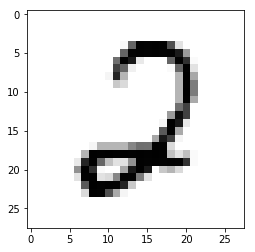

In [47]:
[context_xy, target_x], target_y, labels_y = generate_data(1, 400, testing=True, digit = 2, labels = True, img_rows = 28, img_cols = 28)
plt.imshow(np.array(target_y[0]).reshape([28,28]), cmap='Greys', vmin=0, vmax=1)
print("Digit: ",labels_y[0,0])

___


In [7]:
def log_prob(y_true, y_pred):
    mu, sigma = tf.split(y_pred, 2, axis=-1)

    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    log_p = dist.log_prob(y_true)
    
    loss = -K.mean(log_p)
    
    return loss

___


In [8]:
"""encoder"""
input_context_xy = Input((None, 3), name="Input_layer_contxt_xy") # [num_pts, 2]
input_target_x = Input((None, 2), name="Input_layer_target_x")  # [num_pts, 1]

encoder = input_context_xy

encoder = Dense(128, activation='relu', name="Encoder_layer_0")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_1")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_2")(encoder)
representation_r_i = Dense(128, activation='linear', name="Encoder_layer_3")(encoder)


"""aggregate"""
representation_r = Lambda(lambda x: K.mean(x, axis=-2), name="Mean_layer_r")(representation_r_i)


"""decoder"""
representation_r_tiled = Lambda(lambda x: K.tile(K.expand_dims(x, axis=-2), [1, K.shape(input_target_x)[-2], 1]), name="Tile_layer_r")(representation_r)

decoder_input = Concatenate(axis=-1, name="Concat_layer_r_target_x")([representation_r_tiled, input_target_x])
decoder = Dense(128, activation='relu', name="Decoder_layer_0")(decoder_input)
decoder = Dense(128, activation='relu', name="Decoder_layer_1")(decoder)
decoder = Dense(2, activation='linear', name="Decoder_layer_2")(decoder)

mu, log_sigma = Lambda(lambda x: tf.split(x, 2, axis=-1), name="Split_layer")(decoder)
sigma = Lambda(lambda x: 0.1 + 0.9 * K.softplus(x), name="Softplus_layer_sigma")(log_sigma)


"""build model"""
output = Concatenate(axis=-1, name="Concat_layer_mu_sigma")([mu, sigma])

model = Model([input_context_xy, input_target_x], output)

model.compile(loss=log_prob, optimizer='adam')

model.summary()

# model.load_weights("CNP_mnist_3.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_contxt_xy (InputLay (None, None, 3)      0                                            
__________________________________________________________________________________________________
Encoder_layer_0 (Dense)         (None, None, 128)    512         Input_layer_contxt_xy[0][0]      
__________________________________________________________________________________________________
Encoder_layer_1 (Dense)         (None, None, 128)    16512       Encoder_layer_0[0][0]            
__________________________________________________________________________________________________
Encoder_layer_2 (Dense)         (None, None, 128)    16512       Encoder_layer_1[0][0]            
____________________________________________________________________________________________

___


In [9]:
def plot_functions(inputs, target_y, labels_y, pred):
    
    target_x = np.array(inputs[1][0]).reshape([img_rows, img_cols, 2])
    target_y = np.array(target_y[0]).reshape([img_rows, img_cols])
    label = labels_y[0,0]
    context_x = np.array(np.round(np.matmul(inputs[0][0, :, 0:2], [[img_rows, 0], [0, img_cols]])), dtype='uint16')
    context_y = np.array(np.round(inputs[0][0, :, 2]*255), dtype='uint8')

    context_img = np.zeros([img_rows, img_cols, 3], dtype='uint8')
    context_img[:,:,2] = 255 # set background blue
    for i in range(context_x.shape[0]):
        context_img[context_x[i,0], context_x[i,1], :] = 255 - context_y[i]

    pred_y = np.array(pred[0, :, 0]).reshape([img_rows, img_cols])
    var = np.array(pred[0, :, 1]).reshape([img_rows, img_cols])    
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, figsize=(6,6))
    ax1.imshow(target_y, cmap='Greys', vmin=0, vmax=1)
    ax1.set_title("True", fontsize = 12)
    ax2.imshow(pred_y, cmap='Greys', vmin=0, vmax=1)
    ax2.set_title("Predict", fontsize = 12)
    
    ax3.imshow(context_img)
    ax3.set_title("Context Points: Num pts=%i/%i" % (context_x.shape[0], img_rows*img_cols), fontsize = 12)
    
    ax4.imshow(var, cmap='Greys', vmin=0, vmax=1)
    ax4.set_title("Variance", fontsize = 12)
    
    fig.suptitle("Digit: %i" % label, fontsize = 14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    plt.show()

---

In [12]:
MAX_CONTEXT_POINTS = 5e2

repeats = 10
epochs = 20
steps_per_epoch = 2e2
steps_per_validation = 1e2
batch_size = 64

log: r10, e10, spe2e2, spv1e2, b64 &nbsp;&nbsp;&nbsp; CNP_mnist_1.h5<br>
log: r20, e20, spe2e2, spv1e2, b64 &nbsp;&nbsp;&nbsp; CNP_mnist_2.h5<br>
log: r10, e20, spe2e2, spv1e2, b64 &nbsp;&nbsp;&nbsp; CNP_mnist_3.h5<br>
Total Train: 140000 iterations of batch size 64

Training model
*****************************
Repeat 1
Epoch 1/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9248 - val_loss: -0.8527
Epoch 2/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9233 - val_loss: -1.1896
Epoch 3/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9145 - val_loss: -0.9443
Epoch 4/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9121 - val_loss: -0.9570
Epoch 5/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9174 - val_loss: -0.9471
Epoch 6/20
200/200 [==============================] - 19s 94ms/step - loss: -0.9191 - val_loss: -0.9884
Epoch 7/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9209 - val_loss: -0.9721
Epoch 8/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9144 - val_loss: -0.8078
Epoch 9/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9262 - val_loss: -0.3447
Epoch 10/2

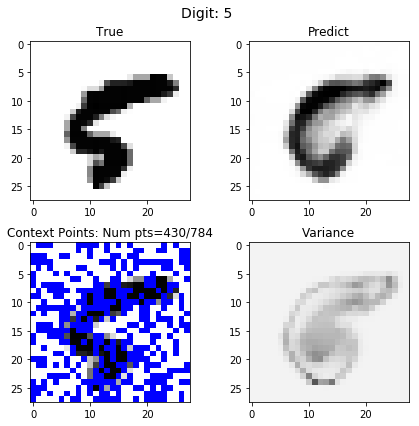

*****************************
Repeat 2
Epoch 1/20
200/200 [==============================] - 19s 95ms/step - loss: -0.9241 - val_loss: -0.9650
Epoch 2/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9194 - val_loss: -1.0204
Epoch 3/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9270 - val_loss: -0.7820
Epoch 4/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9047 - val_loss: -0.9622
Epoch 5/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9168 - val_loss: -0.9180
Epoch 6/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9163 - val_loss: -1.2175
Epoch 7/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9116 - val_loss: -0.5804
Epoch 8/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9068 - val_loss: -0.7235
Epoch 9/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9079 - val_loss: -0.7264
Epoch 10/20
200/200 [====

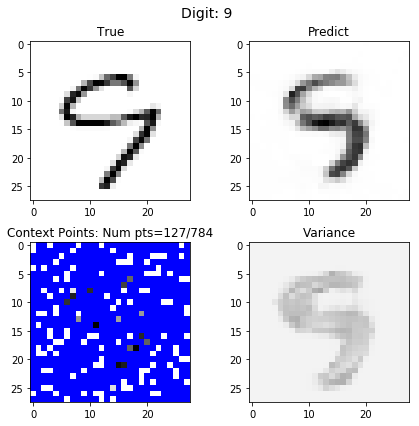

*****************************
Repeat 3
Epoch 1/20
200/200 [==============================] - 19s 95ms/step - loss: -0.9296 - val_loss: -1.0569
Epoch 2/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9035 - val_loss: -0.8276
Epoch 3/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9256 - val_loss: -1.0734
Epoch 4/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9131 - val_loss: -0.9364
Epoch 5/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9279 - val_loss: -0.8432
Epoch 6/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9247 - val_loss: -0.8133
Epoch 7/20
200/200 [==============================] - 18s 88ms/step - loss: -0.9165 - val_loss: -0.8329
Epoch 8/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9145 - val_loss: -1.1833
Epoch 9/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9059 - val_loss: -1.2349
Epoch 10/20
200/200 [====

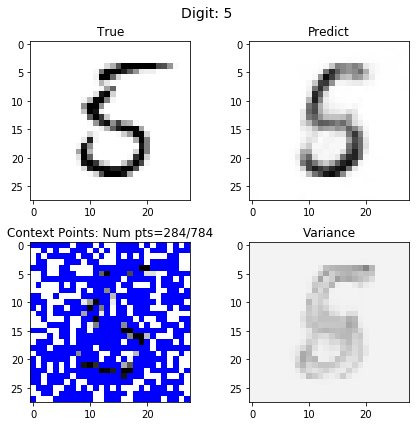

*****************************
Repeat 4
Epoch 1/20
200/200 [==============================] - 19s 94ms/step - loss: -0.9454 - val_loss: -1.1569
Epoch 2/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9308 - val_loss: -0.8237
Epoch 3/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9257 - val_loss: -0.9556
Epoch 4/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9119 - val_loss: -0.8353
Epoch 5/20
200/200 [==============================] - 17s 85ms/step - loss: -0.8986 - val_loss: -0.8303
Epoch 6/20
200/200 [==============================] - 18s 88ms/step - loss: -0.9052 - val_loss: -0.7687
Epoch 7/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9153 - val_loss: -0.7486
Epoch 8/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9204 - val_loss: -0.7626
Epoch 9/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9304 - val_loss: -1.0733
Epoch 10/20
200/200 [====

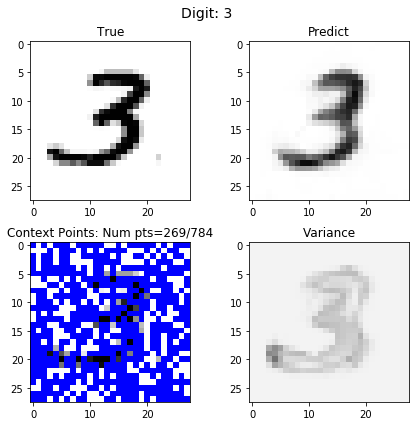

*****************************
Repeat 5
Epoch 1/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9148 - val_loss: -0.9572
Epoch 2/20
200/200 [==============================] - 19s 94ms/step - loss: -0.9280 - val_loss: -0.9252
Epoch 3/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9171 - val_loss: -0.7943
Epoch 4/20
200/200 [==============================] - 19s 95ms/step - loss: -0.9311 - val_loss: -1.0654
Epoch 5/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9238 - val_loss: -1.0754
Epoch 6/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9115 - val_loss: -0.4061
Epoch 7/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9183 - val_loss: -1.0996
Epoch 8/20
200/200 [==============================] - 17s 86ms/step - loss: -0.9226 - val_loss: -1.0482
Epoch 9/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9225 - val_loss: -0.7727
Epoch 10/20
200/200 [====

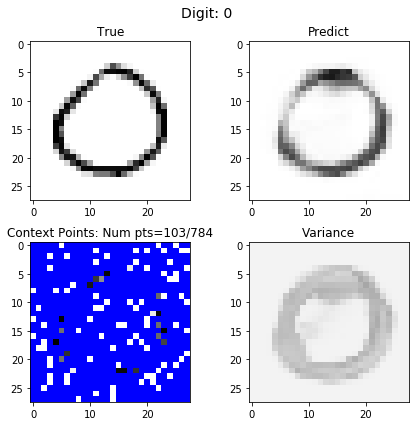

*****************************
Repeat 6
Epoch 1/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9194 - val_loss: -1.0527
Epoch 2/20
200/200 [==============================] - 19s 96ms/step - loss: -0.9452 - val_loss: -1.0287
Epoch 3/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9136 - val_loss: -1.0396
Epoch 4/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9282 - val_loss: -0.9155
Epoch 5/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9297 - val_loss: -1.2160
Epoch 6/20
200/200 [==============================] - 18s 88ms/step - loss: -0.8976 - val_loss: -1.0663
Epoch 7/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9330 - val_loss: -1.0412
Epoch 8/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9333 - val_loss: -0.6546
Epoch 9/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9180 - val_loss: -1.1666
Epoch 10/20
200/200 [====

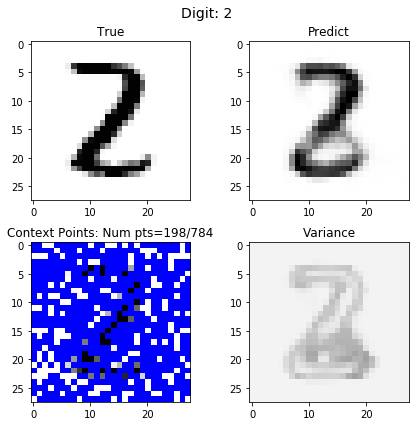

*****************************
Repeat 7
Epoch 1/20
200/200 [==============================] - 18s 88ms/step - loss: -0.8980 - val_loss: -0.8695
Epoch 2/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9202 - val_loss: -1.0396
Epoch 3/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9146 - val_loss: -0.6871
Epoch 4/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9144 - val_loss: -0.7960
Epoch 5/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9227 - val_loss: -0.9078
Epoch 6/20
200/200 [==============================] - 18s 88ms/step - loss: -0.9063 - val_loss: -0.8675
Epoch 7/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9243 - val_loss: -0.9292
Epoch 8/20
200/200 [==============================] - 18s 88ms/step - loss: -0.9182 - val_loss: -0.9811
Epoch 9/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9303 - val_loss: -0.8242
Epoch 10/20
200/200 [====

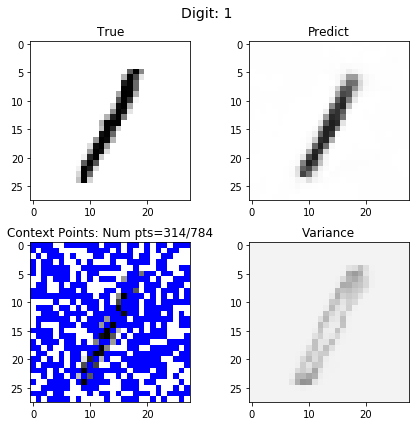

*****************************
Repeat 8
Epoch 1/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9362 - val_loss: -0.9718
Epoch 2/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9184 - val_loss: -0.5815
Epoch 3/20
200/200 [==============================] - 19s 94ms/step - loss: -0.9313 - val_loss: -0.9738
Epoch 4/20
200/200 [==============================] - 18s 88ms/step - loss: -0.9152 - val_loss: -0.7753
Epoch 5/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9254 - val_loss: -0.8707
Epoch 6/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9267 - val_loss: -1.0906
Epoch 7/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9168 - val_loss: -0.9632
Epoch 8/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9191 - val_loss: -0.9598
Epoch 9/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9092 - val_loss: -1.0363
Epoch 10/20
200/200 [====

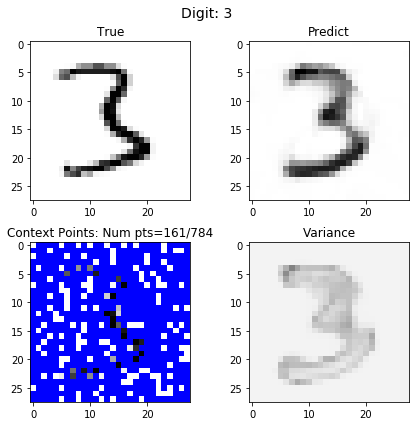

*****************************
Repeat 9
Epoch 1/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9302 - val_loss: -1.1782
Epoch 2/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9170 - val_loss: -0.7409
Epoch 3/20
200/200 [==============================] - 17s 84ms/step - loss: -0.9039 - val_loss: -0.4793
Epoch 4/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9204 - val_loss: -1.0000
Epoch 5/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9262 - val_loss: -0.6092
Epoch 6/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9245 - val_loss: -0.8984
Epoch 7/20
200/200 [==============================] - 19s 93ms/step - loss: -0.9113 - val_loss: -1.0094
Epoch 8/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9121 - val_loss: -1.0497
Epoch 9/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9172 - val_loss: -0.8086
Epoch 10/20
200/200 [====

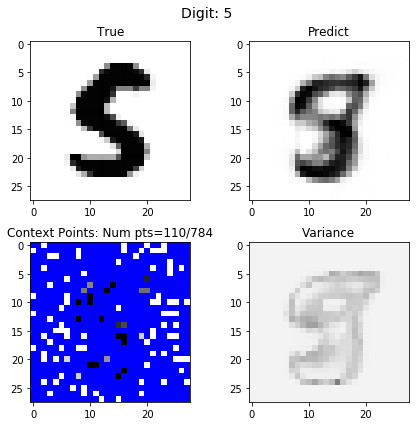

*****************************
Repeat 10
Epoch 1/20
200/200 [==============================] - 18s 91ms/step - loss: -0.9379 - val_loss: -1.1032
Epoch 2/20
200/200 [==============================] - 17s 87ms/step - loss: -0.9272 - val_loss: -0.7320
Epoch 3/20
200/200 [==============================] - 18s 89ms/step - loss: -0.9261 - val_loss: -0.7053
Epoch 4/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9363 - val_loss: -0.9344
Epoch 5/20
200/200 [==============================] - 18s 88ms/step - loss: -0.9246 - val_loss: -0.7457
Epoch 6/20
200/200 [==============================] - 18s 90ms/step - loss: -0.9199 - val_loss: -1.2120
Epoch 7/20
200/200 [==============================] - 18s 88ms/step - loss: -0.9245 - val_loss: -0.8236
Epoch 8/20
200/200 [==============================] - 19s 95ms/step - loss: -0.9350 - val_loss: -1.1883
Epoch 9/20
200/200 [==============================] - 18s 92ms/step - loss: -0.9380 - val_loss: -0.6143
Epoch 10/20
200/200 [===

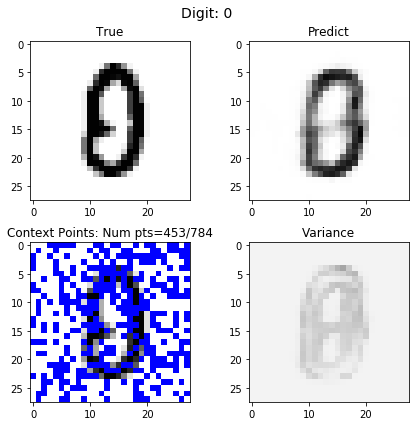

In [13]:
print('Training model')

hist = np.zeros([2, repeats*epochs], dtype='float32')

for i in range(repeats):
    print("*****************************")
    print("Repeat %i" % (i+1))
    history = model.fit_generator(
                    generate(batch_size, MAX_CONTEXT_POINTS, testing=False),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=generate(1, MAX_CONTEXT_POINTS, testing=True),
#                     callbacks=[ModelCheckpoint('CNP_mnist_x.h5', monitor='val_loss', save_best_only=True)],
                    validation_steps=steps_per_validation)
    
    hist[0,i*epochs:(i+1)*epochs] = history.history['loss']
    hist[1,i*epochs:(i+1)*epochs] = history.history['val_loss']
    
    inputs, target_y, labels_y = generate_data(1, MAX_CONTEXT_POINTS, testing=True, labels = True)
    pred = model.predict(inputs, steps=1)

    plot_functions(inputs, target_y, labels_y, pred)

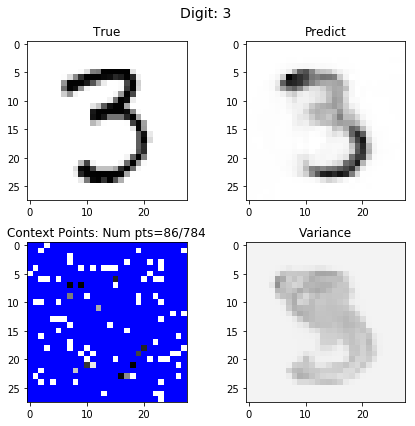

In [22]:
inputs, target_y, labels_y = generate_data(1, 500, testing=True, digit=3, labels = True)
pred = model.predict(inputs, steps=1)

plot_functions(inputs, target_y, labels_y, pred)

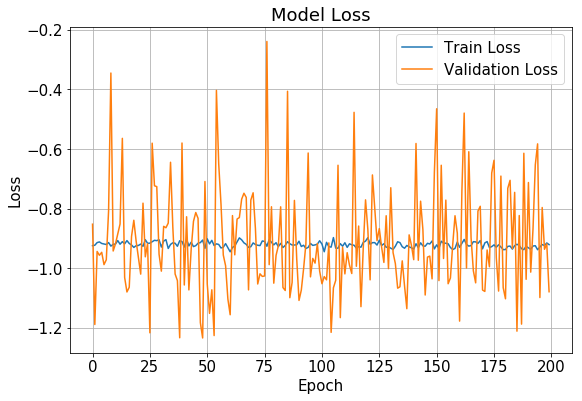

In [23]:
plt.figure(figsize=(9,6))
plt.plot(hist[0])
plt.plot(hist[1])
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.show()

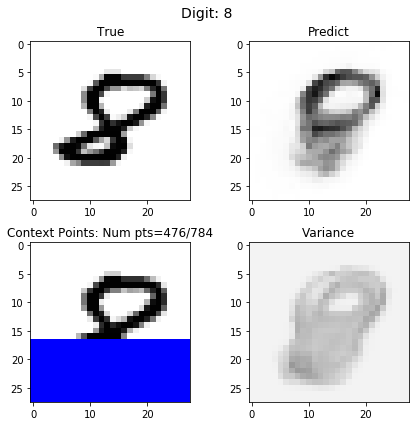

In [44]:
max_num_points = img_rows*img_cols
num_context = 476

# [img_rows, img_cols]
row_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_rows, dtype='float32'), axis=0), [img_cols,1])
# [img_cols, img_rows]
col_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_cols, dtype='float32'), axis=0), [img_rows,1])
# [img_rows*img_cols, 2]
x_pairs = np.reshape(np.concatenate((np.expand_dims(np.transpose(row_dim), axis=-1), np.expand_dims(col_dim, axis=-1)), axis=-1), [max_num_points,2])

context_x = np.zeros([1, num_context, 2])
context_y = np.zeros([1, num_context, 1])

target_x = np.zeros([1, max_num_points, 2])
target_y = np.zeros([1, max_num_points, 1])

labels_y = np.zeros([1, 1], dtype='int8')


labels_y[0] = y_test[61]
img = np.reshape(x_test[61], [max_num_points,1])/255

context_x[0] = x_pairs[:num_context]
context_y[0] = img[:num_context]

target_x[0] = x_pairs
target_y[0] = img

context_xy = np.concatenate([context_x, context_y], axis=-1)  
inputs = [context_xy, target_x]
pred = model.predict(inputs, steps=1)

plot_functions(inputs, target_y, labels_y, pred)